### Predicting Returns

Team A

This Version was created by Leonard Melnik

### First I imported all the librarys that I will need



In [4]:

from datetime import datetime, timedelta,date
import pandas as pd
from scipy import stats
import math
from scipy.special import boxcox, inv_boxcox
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from __future__ import division


#import Keras
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

SyntaxError: from __future__ imports must occur at the beginning of the file (<ipython-input-4-46fe8818d240>, line 12)

# Data Preprocessing
##### The Delivery Volume is a modified version of the data we were given. I removed the first three days because they lacked any substancial data and would pollute any results

##### I also decided to import the Dow Jones, just incase its data would prove its correlation

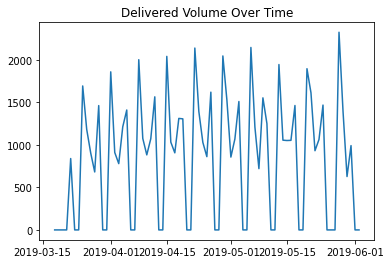

In [3]:
df_volume = pd.read_csv('https://raw.githubusercontent.com/lennymelnik/pb_dataChallenge/master/data/Delivery_Volume1.csv', index_col=['DELIVERY_DATE'], parse_dates=['DELIVERY_DATE'])



df_volume.sort_index(inplace=True)

df_volume['dji'] = df_dji['Adj Close']


df_volume=df_volume.fillna(0)
ts = df_volume['DELIVERED_VOLUME']
plt.plot(df_volume.index.values, df_volume['DELIVERED_VOLUME'])
plt.title("Delivered Volume Over Time")
plt.show()

# What I was able to understand from the data
If you look at the plot above, you can see that after there are no returns, there will always be a spike. And that spike is going to be the highest amount of returns that will happen that week.

The longer people cannot return products, the higher the spike will be. 

If you look at the last spike you can see it is much higher than the others. This is because it was memorial day weekend. Where people were unable to return anything for a longer period of time. So they had more saved up to return.

#Test If the Data is stationary

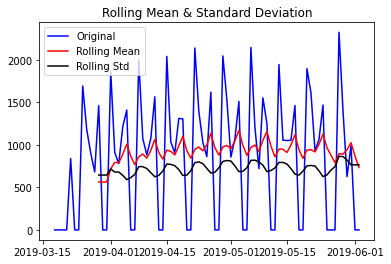

Results of Dickey-Fuller Test:
Test Statistic                 -4.205006
p-value                         0.000646
#Lags Used                      8.000000
Number of Observations Used    68.000000
Critical Value (1%)            -3.530399
Critical Value (5%)            -2.905087
Critical Value (10%)           -2.590001
dtype: float64


In [4]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(ts)


#Test statistic is lower than the critial value. Therefore the data is stationary

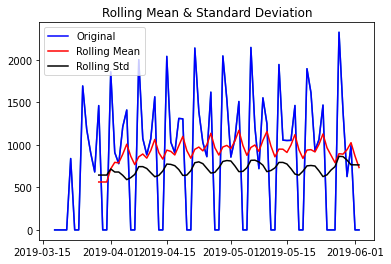

Results of Dickey-Fuller Test:
Test Statistic                 -4.205006
p-value                         0.000646
#Lags Used                      8.000000
Number of Observations Used    68.000000
Critical Value (1%)            -3.530399
Critical Value (5%)            -2.905087
Critical Value (10%)           -2.590001
dtype: float64


In [8]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf




plt.plot(ts)

ts_diff = ts - ts.shift()
ts_diff[0] = 0


#Starting ARIMA

#AR

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


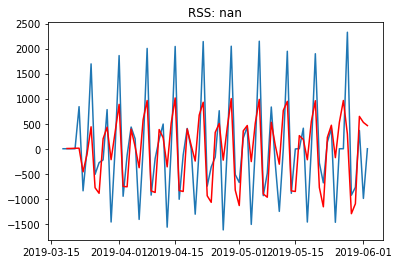

In [9]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts, order=(3, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_diff)**2))
plt.show()




#MA

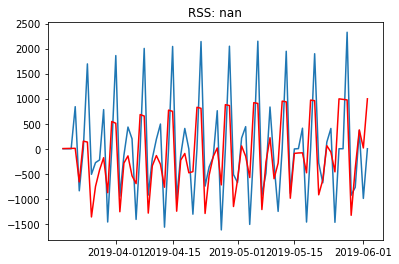

In [202]:

model = ARIMA(ts, order=(0, 1, 1))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_diff)**2))
plt.show()

#Combined

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


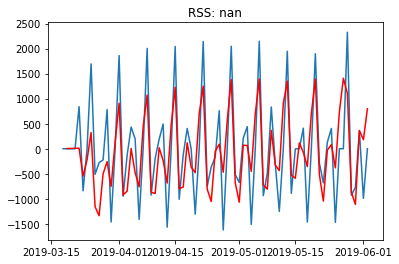

In [10]:

model = ARIMA(ts, order=(2, 1,2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_diff)**2))
plt.show()



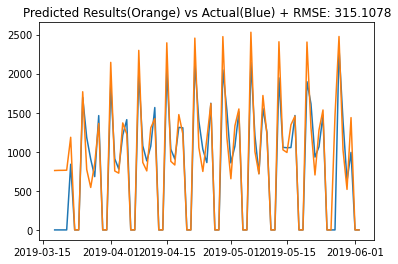

Prediction for June 3 - 7 [1390.92881181 1373.76161072 1104.57099455 1169.0201629  1277.37031839]


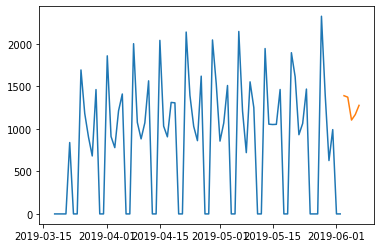

In [16]:
#Recombine

predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)

predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()


ts_predict = ts
ts_predict = ts_predict.add(predictions_ARIMA_diff,fill_value=0)
#ts_predict[ts_predict < 0 ]= abs(ts_predict)
minimum = ts_predict.min()

#Scale results down by 2. And since there are negatives, push the entire array up by the lowest value
ts_predict = ts_predict/2 - ts_predict.min()

date_dataFrame = pd.to_datetime(ts_predict.index.values)

#Manually Weekends to zero
for i in range(len(ts_predict)):
    weekday = date_dataFrame[i].weekday()
    if(weekday == 6 or weekday == 5):
      ts_predict[i] = 0




plt.plot(ts)
plt.plot(ts_predict)
plt.title('Predicted Results(Orange) vs Actual(Blue) + RMSE: %.4f'% np.sqrt(sum((ts_predict-ts)**2)/len(ts)))

plt.show()

#Forecast and transform it the same way as the predictions
forecast = results_ARIMA.forecast(5)[0]/2 - minimum
plt.plot(ts)
plt.plot([ts_predict.index[-1] + pd.DateOffset(days=1),ts_predict.index[-1] + pd.DateOffset(days=2),ts_predict.index[-1] + pd.DateOffset(days=3),ts_predict.index[-1] + pd.DateOffset(days=4),ts_predict.index[-1] + pd.DateOffset(days=5)],forecast)

print("Prediction for June 3 - 7",forecast)


Team No.: Team A
Team Members: Leonard Melnik, Amani Quashie, Remi, Daniel Botjia, Rudy Bi
Please provide the following information:
Forecasts: (1391), (1374), (1105), (1169), (1277)

Problem Formation:
What additional features did you create? Please give a name and define each and why you felt it might help you. 
Feature #1: Weekend, 0 or 1 based on if it is a weekend, when the service is not availible, I used this in my LSTM model.
Feature #2: Weekday, Converting the datetime to a value between 0-1 based on what the day of the week is, there are sertain patterns that repeat on a weekly basis, would have used it in an LSTM model. 
Feature #3: Holiday, 1 if it is an observed holiday and 0 otherwise, this is important because if there is a holiday the next day will have a spike (given it is not a weekend), would have used it in an LSTM model. 
Feature #4: Lag, this is just taking the previous day, if one day is high, the next will be low, then high again. In addition lag_7 (a week delay) had some of the best results, confirming my suspicion of every week being nearly the same. I used this in the ARIMA model but only with a one day lag.

Algorithm Methods:
What types of models did you use? Please give a name and define each and why you felt it might help you.

Model Type #1: LSTM, Long-Short term memory which contains modules that lets it keep information over time, since we don't have much data of anomonies such as holidays, it is crucial to retain any information possible. In the end I chose not to go with this model because it only gave me a 30% accuracy, which is not nearly good enough
Model Type #2: ARIMA, a statistical method that can be used to isolate changes in data after removing trend and seasonality, it uses both regression and moving average so it allows for a simple linear regression, after transforming the results it gave me the most accurate forecast.




General Creativity and Explanation 
Explain the purpose of your model and how it might be used by a client (think of different reasons)

- The purpose of my model is to predict patterns in the amount of returns and apply them to forecast future values. The ARIMA model is very flexible and a client could use it to predict the amount of sales they would make in a given week. They could also use it to break down their information to understand the patterns that lie beneath constant growth and trends.

Explain what your model does and how it works – how would you explain it to a non-technical person

-ARIMA predicts future values by assigning different importance weights to historical values, it also removes trend or seasonality. The way it does this is take for example if we had 10 people of different heights. But instead of comparing everyone from shortest to tallest, we take the difference. So if the shortest person is 2 inches shorter than the next, the value we get is 2. It also values more recent events more.

What challenges did you face in model development (technical, organizational, domain knowledge, etc…)

-I had never worked with ARIMA before, and it was definitely worth learning and understanding. Initially I tried to transform the data before predicting. But since there were many 0's, a lot of transformation methods were out of the picture. When the model provided a prediction it had negative values, but thats not possible since there cannot be a negative amount of returns. Due to this I had to transform the predictions, which I did not anticipate.
- Being sure that LSTM would work better it occupied a majority of my time. As soon as David provided the links for ARIMA I realized that it was the better solution.
- ARIMA is also mainly used with only one feature. In the future I would like to futhur develop it so that I may use a similar strategy, but with the other features that were availible for use.

What insights did you have from working on this project (not just the problem but the process)?

- Essentially correlation does not equal causation, for example I had the Dow Jones Industrial average as a feature, and it showed a nearly 80 percent correlation. That just ended up being so because it too is closed on weekends. Yet again I am humbled by the amount of knowledge that is out there and how much there is to learn. Another thing how much having likeminded people around you can help solve problems.
- The brain is like a muscle, if you do not train it. It will get weak. Having not worked on Data Analytics in a couple of months it took me a while to get back into the flow of things. My teammates and I plan on practicing constantly (ex: kaggle) to make sure that when we are given a problem, we know how to think properly to reach a solution

What data would you request to provide a better estimate and why?

-The data I would request would be more specific to the facility. For example the area in which it is located, as well as other details which differ from facility to facility. This would allow us to train the models better for individual facilities.
- In addition more data about anomoies such as holidays. So that we can train the model to associate any missing days, with the following being a spike.
